## STAT 502 LAB

In [1]:
# import library
import pandas as pd
import numpy as np
from scipy import stats
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import statsmodels.api as sm
from statsmodels.formula.api import ols

%matplotlib inline

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# import data
yA = [11.4, 23.7, 17.9, 16.5, 21.1, 19.6]
yB = [26.9, 26.6, 25.3, 28.5, 14.2, 24.3]
yield_data = yA + yB
trt = ["A", "A", "A", "A", "A", "A", "B", "B", "B", "B", "B", "B"]

data = pd.DataFrame({"trt": trt, "yield": yield_data})
print(data)


   trt  yield
0    A   11.4
1    A   23.7
2    A   17.9
3    A   16.5
4    A   21.1
5    A   19.6
6    B   26.9
7    B   26.6
8    B   25.3
9    B   28.5
10   B   14.2
11   B   24.3


### T test

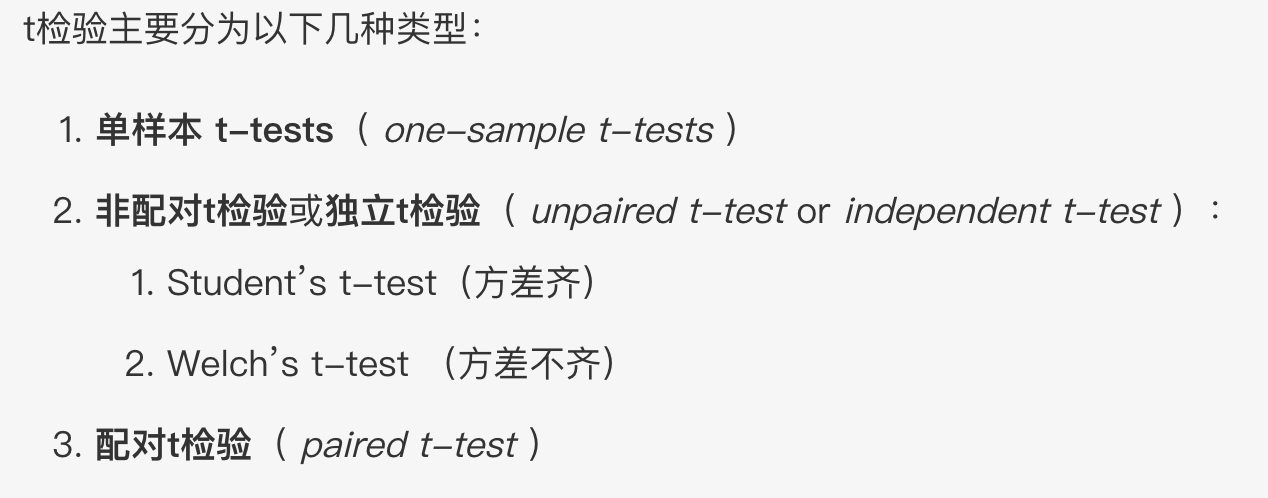

In [3]:
Image(filename='t_test.png')

In [4]:
# run a t-test
# equal variance
ttest_output = stats.ttest_ind(yA, yB, equal_var=True) # 2 independent samples, equal variance
print(ttest_output)

# Accessing individual components of the output
print("Statistic:", ttest_output.statistic)
statistcis = (np.mean(yB) - np.mean(yA))/  np.sqrt(np.var(yB) * (1 / 6 + 1 / 6)) # 2 sample equal variances
print("P-value:", ttest_output.pvalue)
print("Degree of freedom:", ttest_output.df)
df = len(yA) + len(yB) - 2

TtestResult(statistic=-2.1793050332867336, pvalue=0.05430925227007528, df=10.0)
Statistic: -2.1793050332867336
P-value: 0.05430925227007528
Degree of freedom: 10.0


In [5]:
# unequal variance
from scipy.stats import t
# 计算样本大小
nA = np.sum(data['trt'] == "A")
nB = np.sum(data['trt'] == "B")

# 计算两组样本的方差
var_yA = np.var(yA, ddof=1)  # 使用ddof=1表示样本方差，而不是总体方差
var_yB = np.var(yB, ddof=1)

# 计算汇总的方差估计
sp2 = ((nA - 1) * var_yA + (nB - 1) * var_yB) / (nA - 1 + nB - 1)
sp = np.sqrt(sp2)

alpha = 0.05
tcrit = t.ppf(1 - alpha / 2, df=nA + nB - 2) # Percentile Point Function 

# 置信区间估计
mean_diff = np.mean(yB) - np.mean(yA)
ci_lower = mean_diff + np.array([-1, 1]) * sp * np.sqrt(1 / nA + 1 / nB) * tcrit
print("Confidence Interval:", ci_lower)

# 假设检验的p值
t_stat = (np.mean(yB) - np.mean(yA)) / (sp * np.sqrt(1 / nA + 1 / nB))
p_value = 2 * (1 - t.cdf(np.abs(t_stat), df=nA + nB - 2)) # T test
# p_value = 2 * (1 - norm.cdf(np.abs(Z))) Z test
print("P-value:", p_value)

ttest_output = stats.ttest_ind(yA, yB, equal_var=True) # 2 independent samples, unequal variance
print(ttest_output)

Confidence Interval: [-0.132954   11.99962067]
P-value: 0.054309252270075214
TtestResult(statistic=-2.1793050332867336, pvalue=0.05430925227007528, df=10.0)


In [6]:
mean_A = pd.Series(yA).mean()
np.mean(yA)
summary_A = pd.Series(yA).describe() # only series and dataframe have the function describe()

# Accessing mean from summary statistics
print("Mean:", mean_A)
print("Summary:", summary_A)

Mean: 18.366666666666664
Summary: count     6.000000
mean     18.366667
std       4.234934
min      11.400000
25%      16.850000
50%      18.750000
75%      20.725000
max      23.700000
dtype: float64


### Create Function

In [7]:
def g_median(yA, yB):
    return abs(pd.Series(yA).median() - pd.Series(yB).median())

result_median = g_median(yA, yB)
print("Absolute difference of medians:", result_median)

Absolute difference of medians: 7.200000000000003


### Kolmogorov-Smirnov Test
The t-statistic is only sensitive to differences in means. In contrast, the KS-statistic is
sensitive to any differences in the sample distributions.

In [8]:
def g_ks1(yA, yB):
    return stats.ks_2samp(yA, yB).statistic
g_ks1(yA, yB)

def g_ks2(yA, yB):
    sAB = np.sort(np.unique(yA + yB))
    FA = np.searchsorted(np.sort(yA), sAB, side='right') / len(yA) # empirical cumulative distribution function (ECDF) 
    FB = np.searchsorted(np.sort(yB), sAB, side='right') / len(yB)
    return np.max(np.abs(FA - FB))

result_ks = g_ks2(yA, yB)
print("Kolmogorov-Smirnov Test Statistic:", result_ks)

Kolmogorov-Smirnov Test Statistic: 0.8333333333333334


### Randomization Simulations
If possible randomization schemes is really big, Monte Carlo approximation approach necessary.

随着模拟次数增加，结果会更接近于真实分布，但也会消耗更多的计算资源和时间。

In [9]:
yield_data = np.array(yield_data)
n = len(yield_data)

# Generating all combinations of indices 
all_combinations = list(itertools.combinations(range(n), n // 2)) # 从n个中不放回抽样n/2个的方法个数

# Creating an empty array to store differences in means
g_null = np.zeros(len(all_combinations))

# Calculating differences in means for each combination
for i, indices in enumerate(all_combinations):
    g_null[i] = abs(np.mean(yield_data[list(indices)]) - np.mean(yield_data[list(set(range(n)) - set(indices))]))

# Calculating the p-value
p_value = np.mean(g_null >= np.mean(g_null))
print("P-value:", p_value)

P-value: 0.43073593073593075


### ECDF

[1 2 3 4 5 6]
[1 2 3 4 5 6]


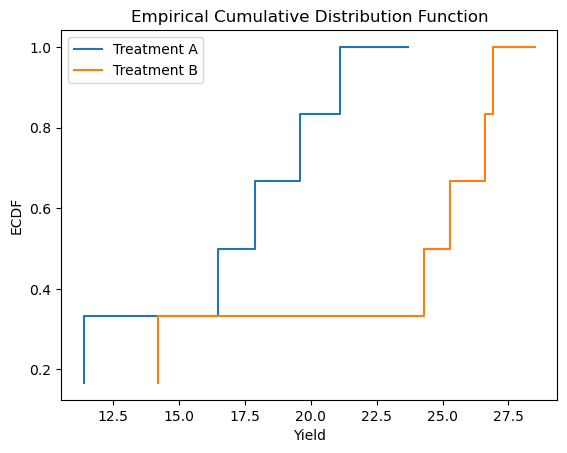

In [10]:
for treatment in data['trt'].unique(): # A or B
    subset = data[data['trt'] == treatment]['yield']
    ecdf = np.sort(subset)
    print(np.arange(1, len(ecdf) + 1))
    y = np.arange(1, len(ecdf) + 1) / len(ecdf)
    plt.step(ecdf, y, label=f'Treatment {treatment}')

# 添加标签和标题
plt.xlabel('Yield')
plt.ylabel('ECDF')
plt.title('Empirical Cumulative Distribution Function')
plt.legend()
plt.show()

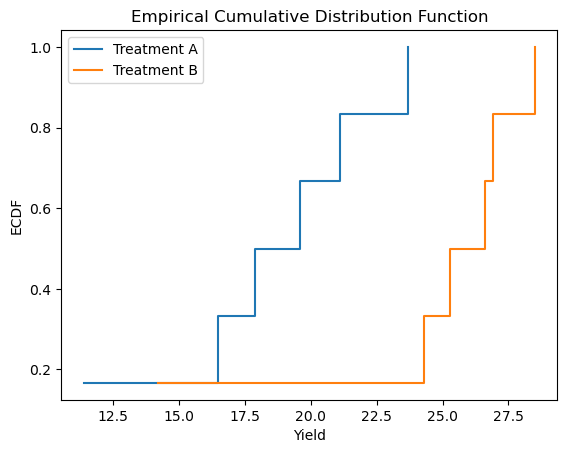

In [11]:
for treatment in data['trt'].unique():
    subset = data[data['trt'] == treatment]['yield']
    ecdf = np.sort(subset)
    y = np.arange(1, len(ecdf) + 1) / len(ecdf)
    plt.step(ecdf, y, label=f'Treatment {treatment}', where='post') # where: 'pre', 'post', 'mid'

plt.xlabel('Yield')
plt.ylabel('ECDF')
plt.title('Empirical Cumulative Distribution Function')
plt.legend()
plt.show()

0 A
1 B


Text(0.5, 0.98, 'Empirical CDFs for Fertlizer Example')

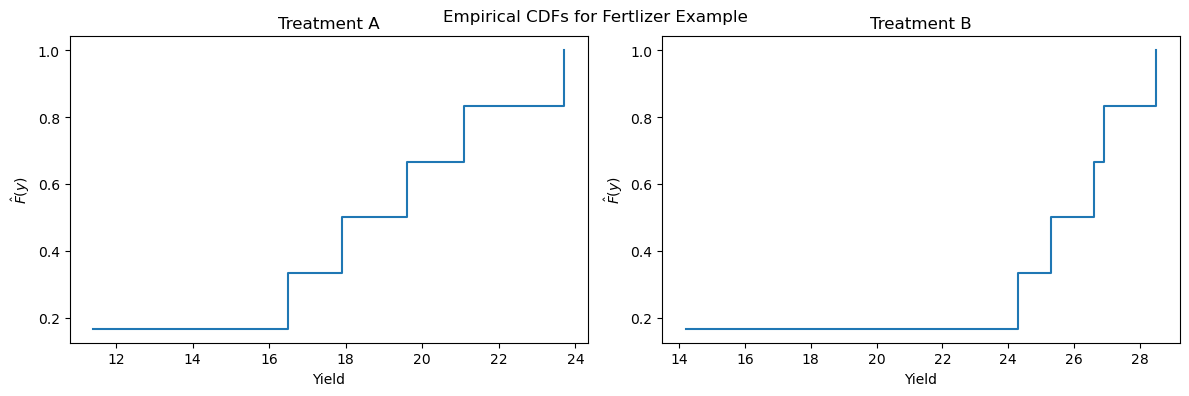

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=data['trt'].nunique(), figsize=(12, 4))  # 创建多个子图

for i, treatment in enumerate(data['trt'].unique()):
    subset = data[data['trt'] == treatment]['yield']
    ecdf = np.sort(subset)
    y = np.arange(1, len(ecdf) + 1) / len(ecdf)
    print(i ,treatment) # index, value
    # 绘制在不同子图上
    axs[i].step(ecdf, y, label=f'Treatment {treatment}', where='post')
    axs[i].set_xlabel('Yield')
    axs[i].set_ylabel(r'$\hat{F}(y)$')  # 使用LaTeX语法添加y标签
    axs[i].set_title(f'Treatment {treatment}')

plt.tight_layout()
plt.suptitle('Empirical CDFs for Fertlizer Example')

### Statistical Power and Sample Size
- TTestPower() 则是适用于配对样本 t 检验的统计功效计算。这用于研究中对同一群体的两次测量之间进行 t 检验的情况。
- TTestIndPower() 是用于独立样本 t 检验的统计功效计算。适用于研究中两个独立样本（例如两个不同的群组）的 t 检验的统计功效计算。


In [13]:
df = nA + nB - 2
delta = (np.mean(yB) - np.mean(yA)) / np.sqrt(np.var(data['yield'])) # scaled effect size

from statsmodels.stats.power import TTestIndPower 
  
power_calculator = TTestIndPower()
power = power_calculator.power(effect_size=delta, nobs1=nA, alpha=0.05, df=df)
print("Statistical power:", power)

Statistical power: 0.42752297406612055


In [14]:
sample_size = power_calculator.solve_power(effect_size=delta, alpha=0.05, power=0.8, alternative='two-sided')
print("Required Sample Size:", round(sample_size)) # 每组的size

Required Sample Size: 13


 Normality Assumption + Independence Assumption

### ANOVA
There are three assumptions of ANOVA:
- a. Independent Observations
- b. Normality of data (and thus normality of residuals)
- c. Equal Variance 

In [15]:
lettuce = pd.read_csv('lettuce.csv')
lettuce

,Nitrogen,Yield
0,0,104
1,0,114
2,0,90
3,0,107
4,50,134
5,50,130
6,50,144
7,50,150
8,100,146
9,100,142


使用ols函数指定了线性回归模型，其中'Yield'是因变量，'Nitrogen'是自变量，并将模型拟合到名为lettuce的数据集上。OLS Regression：最小二乘回归

.fit()方法对指定的模型进行拟合，得到了线性回归模型的结果，并将结果赋给了lettuce_mod_f1这个变量。

In [16]:
# Fit a linear regression model
lettuce_mod_f1 = ols('Yield ~ C(Nitrogen)', data=lettuce).fit() # C(Nitrogen) treats Nitrogen as a categorical variable.
print("MSE:", lettuce_mod_f1.mse_resid)
# Perform ANOVA
anova_results = sm.stats.anova_lm(lettuce_mod_f1, typ=2)
print(lettuce_mod_f1.summary())
print(anova_results)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
MSE: 73.83333333333333
                            OLS Regression Results                            
Dep. Variable:                  Yield   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     24.76
Date:                Fri, 01 Dec 2023   Prob (F-statistic):           1.86e-06
Time:                        16:37:18   Log-Likelihood:                -68.520
No. Observations:                  20   AIC:                             147.0
Df Residuals:                      15   BIC:                             152.0
Df Model:                           4                                         
Covariance Type:

With a pval < 0.001 there is strong evidence that at least one Nitrogen Treatment is different from another in terms of the Lettuce Yield.

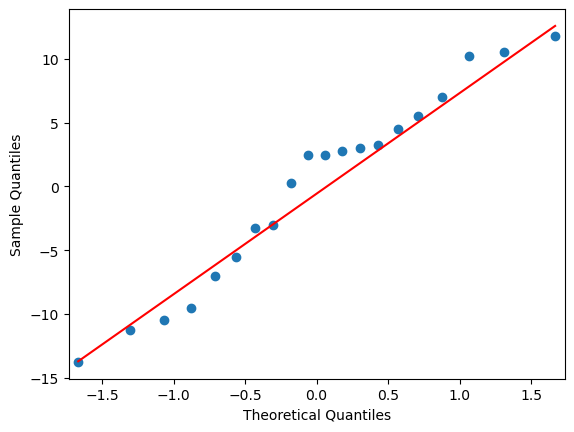

In [17]:
# 获取残差
residuals = lettuce_mod_f1.resid

# 绘制QQ图
sm.qqplot(residuals, line='q')
plt.show()

贴合直线，符合正态分布

In [18]:
lettuce_groupmeans = ols('Yield ~ -1 + C(Nitrogen)', data=lettuce).fit() 
print("MSE:", lettuce_groupmeans.mse_resid)
# Display the summary of group means
print(lettuce_groupmeans.summary()) # 去除截距项的情况下，coef可以被解释为组平均值。

# Obtain confidence intervals for the estimates (group means)
conf_int = lettuce_groupmeans.conf_int()
print("Confidence Intervals for Group Means:")
print(conf_int) 

anova_results2 = sm.stats.anova_lm(lettuce_groupmeans, typ=2)
print(anova_results2)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
MSE: 73.83333333333333
                            OLS Regression Results                            
Dep. Variable:                  Yield   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     24.76
Date:                Fri, 01 Dec 2023   Prob (F-statistic):           1.86e-06
Time:                        16:37:18   Log-Likelihood:                -68.520
No. Observations:                  20   AIC:                             147.0
Df Residuals:                      15   BIC:                             152.0
Df Model:                           4                                         
Covariance Type:

C(Nitrogen) -> treatment; Residual -> noise

用 ols('Yield ~ -1 + C(Nitrogen)', data=lettuce).fit() 将移除截距项，因此每个因子水平的系数将直接对应于组平均值。这对于你只对组平均值感兴趣，而不需要截距项时非常有用。这种方法不会对一个水平进行基线比较，而是将每个水平作为独立的实体来对待。

而使用 ols('Yield ~ C(Nitrogen)', data=lettuce).fit() 将包括截距项，因此每个因子水平的系数将表示相对于截距项（参考水平）的效应。这对于想要观察每个因子水平相对于一个参考水平的效应时非常有用。这个模型将为每个水平生成一个虚拟变量，并对每个水平的效应进行比较。

因此，根据你的研究目的和对因子水平效应的解释，你可以选择合适的模型形式。

### Multiple Comparisons
在进行方差分析(ANOVA)后，如果我们发现组均值之间存在显著差异，Multiple Comparisons则用于进一步确定哪些组之间存在差异。多重比较方法可以有效探测在ANOVA中拒绝了总体均值相等的假设后，哪些组之间的均值确实存在差异。
- Tukey's HSD: 通过计算所有组均值之间的配对比较来检测哪些组之间存在显著差异。Tukey方法控制了整体的类型I错误率，对于同一组实验中的多组比较而言是一种保守且有效的方法。
- Dunnett: 假设有一个对照组，然后检验其他处理组与对照组之间的差异。这种方法适用于实验设计中存在对照组的情况。
- Scheffe: 适用于比较多组均值之间的所有可能组合。它是一种保守的方法，通常用于小样本和不均匀方差的情况。Scheffe方法可以控制整体的类型I错误率，但可能对显著性检验的结果要求较高。

In [19]:
np.random.seed(101)
n = 5
# 生成随机数据
y1 = np.random.normal(0, 1, n) # mean:0 ; sd: 1
y2 = np.random.normal(1, 1, n)
y3 = np.random.normal(2, 1, n)
y4 = np.random.normal(0, 1, n)
# 创建数据框
data = {
    'y': np.concatenate([y1, y2, y3, y4]),
    'trt': np.repeat(["A", "B", "C", "D"], n)
}
dat_exp = pd.DataFrame(data)
dat_exp

,y,trt
0,2.706850,A
1,0.628133,A
2,0.907969,A
3,0.503826,A
4,0.651118,A
5,0.680682,B
6,0.151923,B
7,1.605965,B
8,-1.018168,B
9,1.740122,B


In [20]:
# Tukey HSD
from statsmodels.stats.multicomp import pairwise_tukeyhsd

model = ols('y ~ trt', data=dat_exp).fit()

# 进行方差分析并执行Tukey HSD多重比较
tukey_results = pairwise_tukeyhsd(dat_exp['y'], dat_exp['trt'], alpha=0.05)

# 打印多重比较结果
print(tukey_results)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     A      B  -0.4475 0.8731 -2.1427 1.2477  False
     A      C   0.6077 0.7372 -1.0875 2.3029  False
     A      D   0.2032 0.9856  -1.492 1.8984  False
     B      C   1.0552 0.3177   -0.64 2.7504  False
     B      D   0.6507 0.6956 -1.0445 2.3459  False
     C      D  -0.4045 0.9022 -2.0997 1.2907  False
---------------------------------------------------


reject 为 False 时，意味着在对应的组之间不拒绝零假设，即认为这两组之间没有显著差异。

### Bonferroni Adjustment & Holm Adjustment

In [21]:
from statsmodels.stats.multitest import multipletests

# Example unadjusted p-values (replace this with your actual unadjusted p-values)
unadjusted_p_values = anova_results['PR(>F)']
unadjusted_p_values2 = anova_results2['PR(>F)']

# Holm correction
adjusted_p_values_holm = multipletests(unadjusted_p_values, method='holm')[1]
print("Unadjusted p-value:", unadjusted_p_values[0])
print("Holm-adjusted p-values:", adjusted_p_values_holm[0])

# Bonferroni correction
adjusted_p_values_bonferroni = multipletests(unadjusted_p_values2, method='bonferroni')[1]
print("Unadjusted p-value:", unadjusted_p_values2[0])
print("Bonferroni-adjusted p-values:", adjusted_p_values_bonferroni[0])

Unadjusted p-value: 1.8573093086868383e-06
Holm-adjusted p-values: 3.7146186173736767e-06
Unadjusted p-value: 1.2358260976106698e-18
Bonferroni-adjusted p-values: 2.4716521952213396e-18


### Completely Randomized Design(CRD) with a Factorial Treatment Structure
Twenty-four pine trees are assigned at random to the eight combinations of whole shape (circular, diagonal slash, check, rectangular) and acid treatment (yes or no).

In [22]:
# import data
resin = [9, 13, 12, 43, 48, 57, 60, 65, 70, 77, 70, 91, 15, 13, 20, 66, 58, 73, 75, 78, 90, 97, 108, 99]
acid = ["No"] * 12 + ["Yes"] * 12
shape = ["Circular"] * 3 + ["Diagonal"] * 3 + ["Check"] * 3 + ["Rect"] * 3
shape = shape * 2
pine_data = pd.DataFrame({'resin': resin, 'acid': acid, 'shape': shape})

pine_data.info()
pine_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   resin   24 non-null     int64 
 1   acid    24 non-null     object
 2   shape   24 non-null     object
dtypes: int64(1), object(2)
memory usage: 704.0+ bytes


,resin,acid,shape
0,9,No,Circular
1,13,No,Circular
2,12,No,Circular
3,43,No,Diagonal
4,48,No,Diagonal
5,57,No,Diagonal
6,60,No,Check
7,65,No,Check
8,70,No,Check
9,77,No,Rect


In [23]:
# Fit the ANOVA model
model = ols('resin ~ acid * shape', data=pine_data).fit() # 考虑两个因子的交互效应
# print(model.summary())
anova_table = sm.stats.anova_lm(model, typ=2) # typ: for BALANCED designs, it doesn't matter which Type you use
print(anova_table)

# Confidence intervals
confidence_intervals = model.conf_int()
print(confidence_intervals)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                  sum_sq    df           F        PR(>F)
acid         1305.375000   1.0   28.954713  6.121506e-05
shape       19407.458333   3.0  143.493222  8.934363e-12
acid:shape    237.458333   3.0    1.755699  1.960810e-01
Residual      721.333333  16.0         NaN           NaN
                                       0          1
Intercept                      56.782043  73.217957
acid[T.Yes]                     4.378054  27.621946
shape[T.Circular]             -65.288612 -42.044721
shape[T.Diagonal]             -27.288612  -4.044721
shape[T.Rect]                   2.711388  25.955279
acid[T.Yes]:shape[T.Circular] -27.769247   5.102580
acid[T.Yes]:shape[T.Diagonal] -16.102580  16.769247
acid[T.Yes]:shape[T.Rect]     -10.435913  22.4359

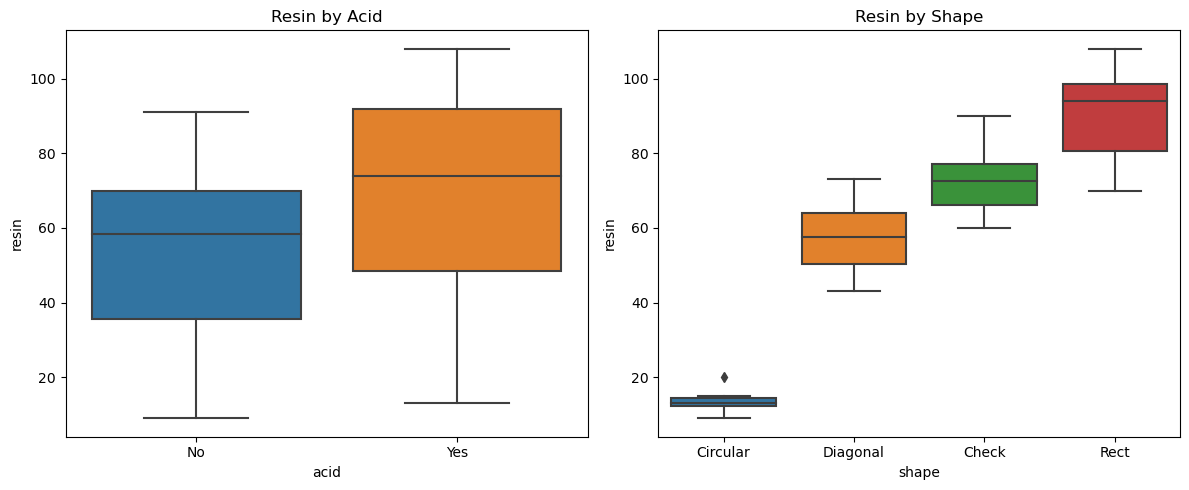

In [24]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x='acid', y='resin', data=pine_data)
plt.title('Resin by Acid')

plt.subplot(1, 2, 2)
sns.boxplot(x='shape', y='resin', data=pine_data)
plt.title('Resin by Shape')

plt.tight_layout()
plt.show()

**Interaction plot**

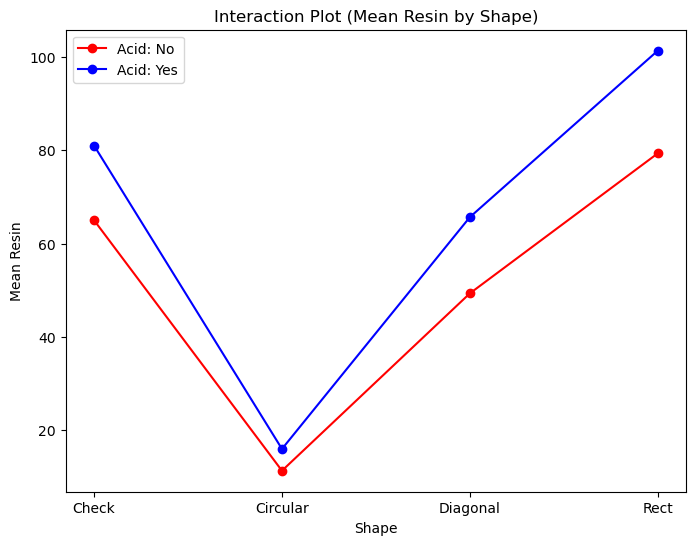

In [31]:
plt.figure(figsize=(8, 6))
resin_means_shape = pine_data.groupby('shape')['resin'].mean().reset_index()
colors = ['red', 'blue', 'green', 'orange'] 
for i, acid_type in enumerate(pine_data['acid'].unique()):
    plt.plot(resin_means_shape['shape'],
             pine_data[pine_data['acid'] == acid_type].groupby('shape')['resin'].mean(),
             marker='o', linestyle='-', color=colors[i],
             label=f'Acid: {acid_type}')

plt.legend()
plt.title('Interaction Plot (Mean Resin by Shape)')
plt.xlabel('Shape')
plt.ylabel('Mean Resin')
plt.show()

In [32]:
resin_means_shape

,shape,resin
0,Check,73.000000
1,Circular,13.666667
2,Diagonal,57.500000
3,Rect,90.333333


if there is no treatment effect, the line will be parallel.

### Randomized Complete Block Design(RCBD)

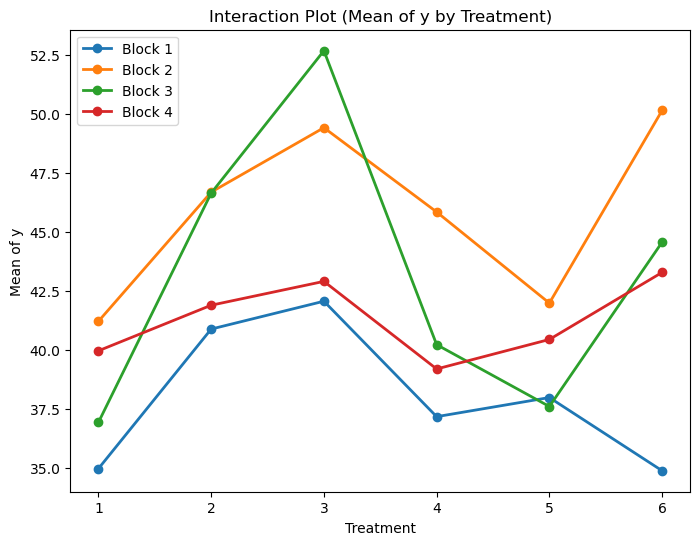

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Data
y = [34.98, 41.22, 36.94, 39.97, 40.89, 46.69, 46.65, 41.90,
     42.07, 49.42, 52.68, 42.91, 37.18, 45.85, 40.23, 39.20,
     37.99, 41.99, 37.61, 40.45, 34.89, 50.15, 44.57, 43.29]
block = list(range(1, 5)) * 6
treatment = [1] * 4 + [2] * 4 + [3] * 4 + [4] * 4 + [5] * 4 + [6] * 4
nitro = pd.DataFrame({'y': y, 'block': block, 'treatment': treatment})
nitro 
# Calculate mean of y for each treatment
mean_y_by_treatment = nitro.groupby('treatment')['y'].mean().reset_index()

# Interaction plot using mean of y for each treatment
plt.figure(figsize=(8, 6))

for i in range(1, 5):
    plt.plot(mean_y_by_treatment['treatment'],
             nitro[nitro['block'] == i].groupby('treatment')['y'].mean(),
             marker='o', linestyle='-', linewidth=2,
             label=f'Block {i}')

plt.legend()
plt.title('Interaction Plot (Mean of y by Treatment)')
plt.xlabel('Treatment')
plt.ylabel('Mean of y')
plt.show()

In [34]:
# Fit the ANOVA model
model = ols('y ~ C(block) + C(treatment)', data=nitro).fit() # 考虑两个因子的单独效应

# ANOVA table
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# Coefficients
print(model.params)

# If you want to calculate Tukey's HSD for multiple comparisons
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey_results = pairwise_tukeyhsd(nitro['y'], nitro['treatment'], alpha=0.05)
print(tukey_results.summary())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                  sum_sq    df         F    PR(>F)
C(block)      197.003933   3.0  9.119842  0.001116
C(treatment)  201.316383   5.0  5.591686  0.004191
Residual      108.008417  15.0       NaN       NaN
Intercept            34.205833
C(block)[T.2]         7.886667
C(block)[T.3]         5.113333
C(block)[T.4]         3.286667
C(treatment)[T.2]     5.755000
C(treatment)[T.3]     8.492500
C(treatment)[T.4]     2.337500
C(treatment)[T.5]     1.232500
C(treatment)[T.6]     4.947500
dtype: float64
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2    5.755 0.3917  -3.4955 15.0055  False
     1      3   8.4925 0.0828   -0.7

What if we performed a paired t-test using BLOCK as the pair?

Using BLOCK as the pair suggests that we're examining differences within each block.

Need to be careful here though on inference:
1. RCBD randomized units to treatments, paired t-test might not do this.
2. Paired t-test might use the exact same unit under two conditions. RCBD would not do this...gets more into Crossover Designs.

### Balanced Incomplete Block Design(BIBD)

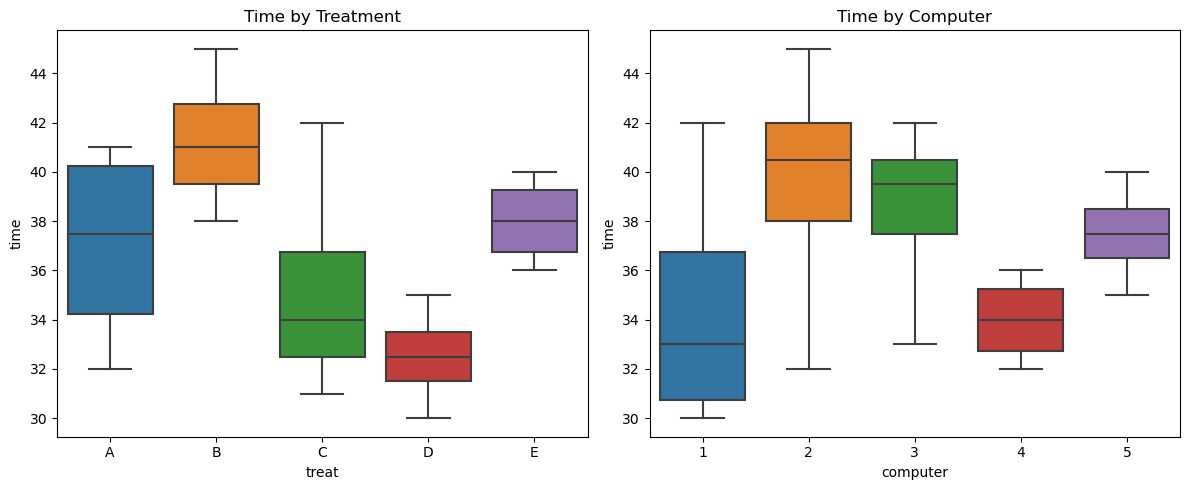

/var/folders/ls/vcn1c9154dz3ps27jhzrm_s40000gn/T/ipykernel_31289/996773918.py:31: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x='treat', y='time', hue='computer', data=cd, markers='o', linestyles='-', ci=None)


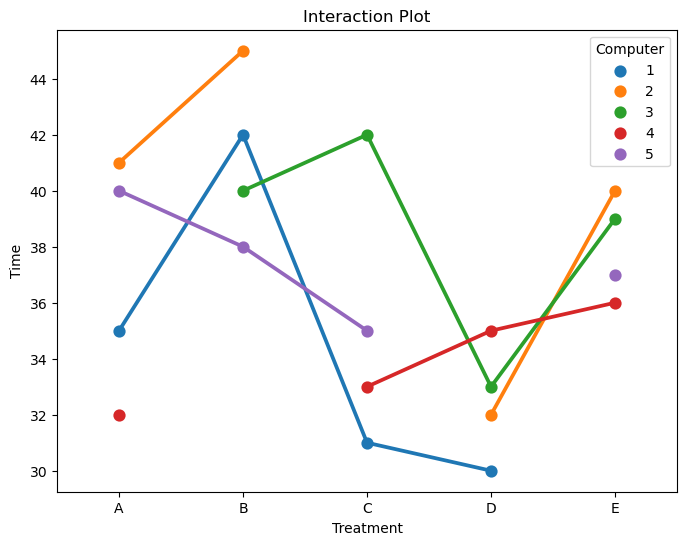

In [35]:
import pyreadr
import pyreadr
import pandas as pd

# Load the RDS file
result = pyreadr.read_r('cd.RDS')

# Extract the first (and possibly only) data frame from the result dictionary
cd = result[None] # 只有一个数据框

# Convert to DataFrame
cd = pd.DataFrame(cd)
cd.head()

# Plot time by treat and computer
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x='treat', y='time', data=cd)
plt.title('Time by Treatment')

plt.subplot(1, 2, 2)
sns.boxplot(x='computer', y='time', data=cd)
plt.title('Time by Computer')

plt.tight_layout()
plt.show()

# Interaction plot equivalent using seaborn
plt.figure(figsize=(8, 6))
sns.pointplot(x='treat', y='time', hue='computer', data=cd, markers='o', linestyles='-', ci=None)
plt.title('Interaction Plot')
plt.xlabel('Treatment')
plt.ylabel('Time')
plt.legend(title='Computer')
plt.show()

In [36]:
cd

,computer,treat,time
0,1,A,35
1,2,A,41
2,3,B,40
3,4,A,32
4,5,A,40
5,1,B,42
6,2,B,45
7,3,C,42
8,4,C,33
9,5,B,38


With incomplete blocks, doing the "interaction plot" is a bit messy to read and interpret.

lineplot is a bit better, but be careful because it connects lines through missing block-treatments.

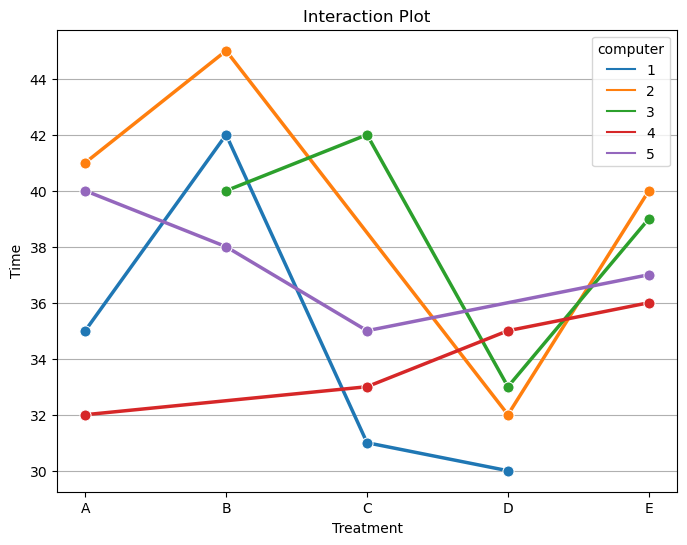

In [37]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='treat', y='time', hue='computer', data=cd, marker='o', markersize=8, linewidth=2.5)
plt.title('Interaction Plot')
plt.xlabel('Treatment')
plt.ylabel('Time')
plt.grid(axis='y')  # Show gridlines on y-axis only
plt.show()

In [38]:
cd_mod = ols('time ~ computer + treat', data=cd).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(cd_mod)
print(anova_table)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
            df  sum_sq    mean_sq         F    PR(>F)
computer   4.0    95.2  23.800000  2.451311  0.107908
treat      4.0   139.2  34.800000  3.584270  0.041790
Residual  11.0   106.8   9.709091       NaN       NaN


In [52]:
# Fit the linear regression model including 'computer' and 'treat' variables
cd_mod = ols('time ~ computer + treat', data=cd).fit()
# Perform pairwise comparisons using Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=cd['time'], groups=cd['treat'], alpha=0.05)
print(tukey.summary())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     A      B     4.25 0.4235  -3.1546 11.6546  False
     A      C    -1.75 0.9461  -9.1546  5.6546  False
     A      D     -4.5   0.37 -11.9046  2.9046  False
     A      E      1.0  0.993  -6.4046  8.4046  False
     B      C     -6.0 0.1423 -13.4046  1.4046  False
     B      D    -8.75 0.0172 -16.1546 -1.3454   True
     B      E    -3.25 0.6631 -10.6546  4.1546  False
     C      D    -2.75 0.7799 -10.1546  4.6546  False
     C      E     2.75 0.7799  -4.6546 10.1546  False
     D      E      5.5 0.2004  -1.9046 12.9046  False
------------------------------------------------

LS Means（最小二乘均值）：这是在线性模型中估计的平均值。在许多统计软件中，当执行线性回归或方差分析等分析时，模型会计算LS means。LS means代表在控制其他因素时，每个因素水平的预期平均响应。它们可用于比较**不同组之间的均值**，而不受其他因素的影响。

- LS Means：这个指标可以提供每个因素水平的预期平均值，帮助你了解在其他因素控制下每组的预期效果。这对于理解实验结果中各组的表现是很有帮助的。
- Multiple Comparisons(eg. TukeyHSD)：当你想要确定哪些组之间存在显著差异时，多重比较方法是必要的。它们可以帮助确定在进行多次比较时如何控制整体的错误率，以及哪些组之间存在显著性差异。